<h1 style="text-align: center; font-size: 36px; color: #3498db; font-weight: bold;">Prosody Tools</h1>

## <h2 style="text-align: center; font-size: 28px; color: #2ecc71; font-weight: bold;">Prosody API Tool</h2>
### <h3 style="text-align: center; font-size: 24px; color: #e74c3c; font-family: 'Arial', sans-serif; font-weight: bold;">Host</h3>


#### Sent voice, Receive the prediction

Received message on topic pros/image/receive1
Received and saved: ./prosody_received/prosody_histogram.png
Sent voice file.
Received message on topic pros/image/receive2
Received and saved: ./prosody_received/prosody_map.png
Received message on topic pros/string/receive
Probabilities: [1.68084851e-04 5.51068366e-01 2.99653858e-01 8.00687075e-02
 1.02593368e-02 2.46093055e-04 2.68627284e-03 5.49698137e-02]
Probabilities saved.
Disconnected from broker.


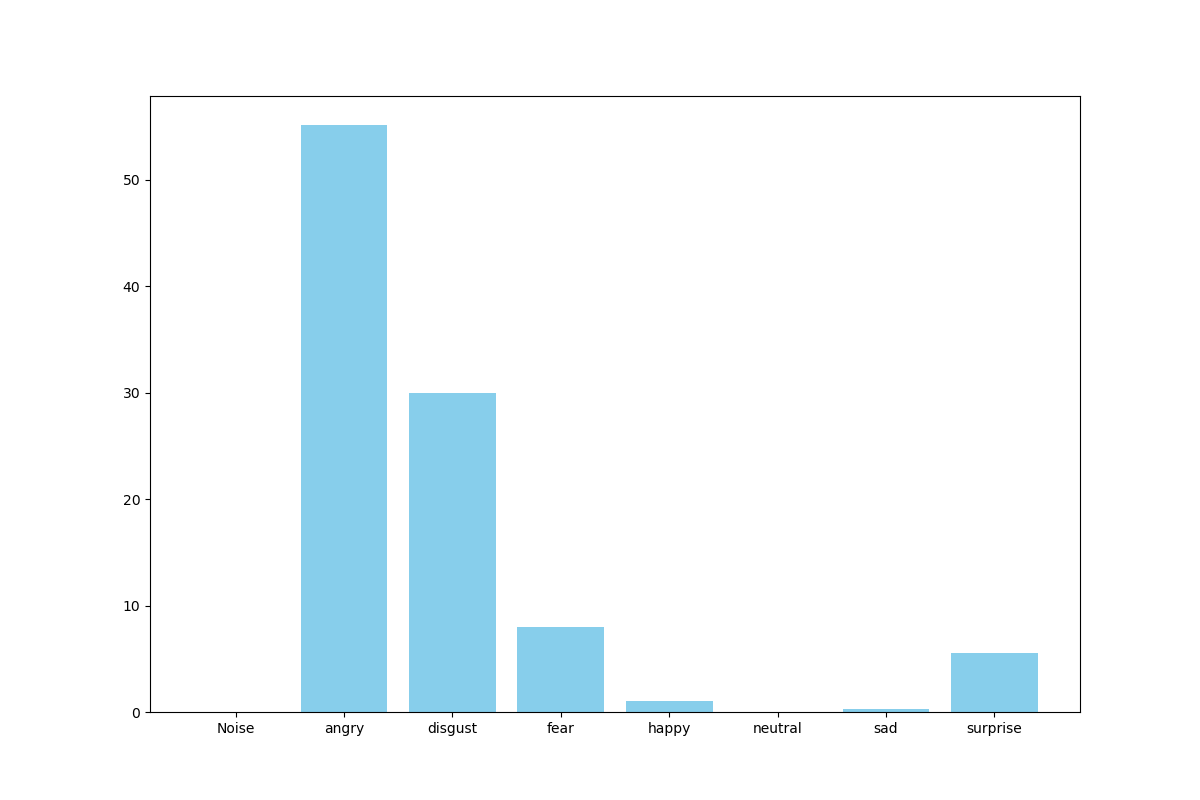

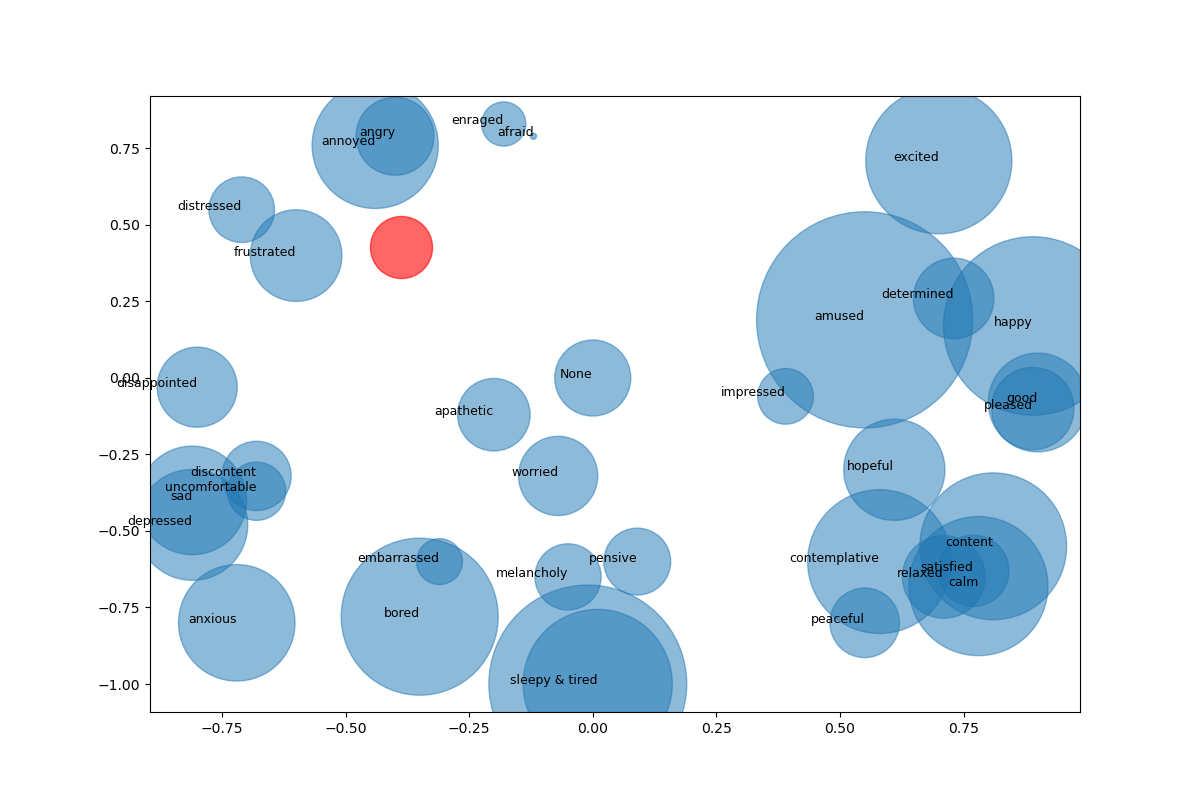

In [1]:
import os
import time
from paho.mqtt import client as mqtt_client

# Host configuration
BROKER_ADDRESS = "tekolabserv.reutlingen-university.de"
broker_port = 18883
username = "hsrt"
password = "M0squitt0HSRTPassw0rt!"
VOICE_TOPIC = "pros/voice/send"
IMAGE1_TOPIC = "pros/image/receive1"
IMAGE2_TOPIC = "pros/image/receive2"
STRING_TOPIC = "pros/string/receive"
client_id = "host"


os.makedirs("./prosody_received", exist_ok=True)
os.makedirs("./voice_send", exist_ok=True)

# Callback
def on_message(client, userdata, message):
    print(f"Received message on topic {message.topic}")

    if message.topic == IMAGE1_TOPIC:
        file_path = "./prosody_received/prosody_histogram.png"
        try:
            with open(file_path, "wb") as f:
                f.write(message.payload)
            print(f"Received and saved: {file_path}")
        except Exception as e:
            print(f"Failed to save {file_path}: {e}")

    elif message.topic == IMAGE2_TOPIC:
        file_path = "./prosody_received/prosody_map.png"
        try:
            with open(file_path, "wb") as f:
                f.write(message.payload)
            print(f"Received and saved: {file_path}")
        except Exception as e:
            print(f"Failed to save {file_path}: {e}")

    elif message.topic == STRING_TOPIC:
        try:
            probabilities = message.payload.decode("utf-8")
            print(f"Probabilities: {probabilities}")

            # Save to a structured file
            with open("./prosody_received/prosody_probabilitie.txt", "w") as f:
                f.write(probabilities)
            print("Probabilities saved.")
        except Exception as e:
            print(f"Failed to process string data: {e}")

# client
client = mqtt_client.Client(mqtt_client.CallbackAPIVersion.VERSION2, client_id)

client.username_pw_set(username, password)
client.on_message = on_message

# Connect to the broker
try:
    client.connect(BROKER_ADDRESS, broker_port)
except Exception as e:
    print(f"Failed to connect to broker: {e}")
    exit(1)

# Subscribe to topics
topics = [IMAGE1_TOPIC, IMAGE2_TOPIC, STRING_TOPIC]
for topic in topics:
    client.subscribe(topic)

client.loop_start()

# Send voice 
voice_file = "./voice_send/voice.wav"
if os.path.exists(voice_file):
    try:
        with open(voice_file, "rb") as f:
            voice_data = f.read()
        client.publish(VOICE_TOPIC, voice_data, retain=True)
        print("Sent voice file.")
    except Exception as e:
        print(f"Failed to send voice file: {e}")
else:
    print(f"Voice file not found: {voice_file}")

time.sleep(3)  # Wait for responses

# Clean messages 
for topic in topics :
    client.publish(topic, "", retain=True)

client.loop_stop()
client.disconnect()
print("Disconnected from broker.")

#####################################################################
# Display the images
from IPython.display import Image, display
image_paths = [
    "./prosody_received/prosody_histogram.png",
    "./prosody_received/prosody_map.png"
]

for image_path in image_paths:
    display(Image(filename=image_path))
#####################################################################

In [2]:
import numpy as np
import pandas as pd
import os

# Define the file paths
text_file_path = './prosody_received/prosody_probabilitie.txt' 
csv_file_path = './prosody_received/prosody_probabilities.csv'  

# Columns 
columns = ['Noise', 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Read the text file 
with open(text_file_path, 'r') as file:
    line = file.read().replace('\n', '').strip()
    #numpy array
    probabilities = np.fromstring(line.strip('[]'), sep=' ')


if not os.path.exists(csv_file_path):
    df = pd.DataFrame([probabilities], columns=columns)
    df.to_csv(csv_file_path, index=False)
else:
    df = pd.read_csv(csv_file_path)
    new_row = pd.DataFrame([probabilities], columns=columns)
    df = pd.concat([df, new_row], ignore_index=True)
    df.to_csv(csv_file_path, index=False)

print(f"Data appended to {csv_file_path}")


Data appended to ./prosody_received/prosody_probabilities.csv
